## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# other useful packages 
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# read the data 
# note that this data file does not live on GitHub, so each team member has saved the file in their local project repo 
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")

# sample 1000 rows to run the code 
# note that random.state has been set to an integer, so hopefully we will get the same sample in each iteration 
congress_tweets = congress_tweets.sample(n=1000, replace=False, random_state= 5, axis= 0)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,Senate,Republican,"163,387","116,454","122,640","164,676"
479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,Senate,Republican,"495,961","284,494","302,081","475,064"
866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,RT @brianstelter 170 days.\n\nhttp://www.cnn.c...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522"
168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,@SenateDems We fought hard to make sure nonpro...,Michael Bennet,Sen,21-Jan-09,11/28/1964,M,CO,Senate,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243"
507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,This illegal act shows once again there is no ...,Albio Sires,Rep,3-Jan-13,1/26/1951,M,NJ,8,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
# drop NA in the 'text' column 
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,Senate,Republican,"163,387","116,454","122,640","164,676"
1,479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,Senate,Republican,"495,961","284,494","302,081","475,064"
2,866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,RT @brianstelter 170 days.\n\nhttp://www.cnn.c...,Don Beyer,Rep,3-Jan-15,6/20/1950,M,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522"
3,168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,@SenateDems We fought hard to make sure nonpro...,Michael Bennet,Sen,21-Jan-09,11/28/1964,M,CO,Senate,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243"
4,507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,This illegal act shows once again there is no ...,Albio Sires,Rep,3-Jan-13,1/26/1951,M,NJ,8,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"


In [5]:
# look at the "text" column 
text = congress_tweets['text']
text

0      Sam &amp; the guys had to deal with a less exp...
1      It was great to @Skype w @StuartPublicSch’s go...
2      RT @brianstelter 170 days.\n\nhttp://www.cnn.c...
3      @SenateDems We fought hard to make sure nonpro...
4      This illegal act shows once again there is no ...
                             ...                        
995    Protecting our Great Lakes is part of our DNA ...
996    Implementing #Huawei technology into national ...
997    Sarah Pitlyk lacks the basic qualifications an...
998    For the fourth consecutive day, Mississippi's ...
999    They provide needed relief for local restauran...
Name: text, Length: 1000, dtype: object

In [6]:
# see what a tweet looks like 
congress_tweets['text'][0]

'Sam &amp; the guys had to deal with a less experienced teammate (me). But we did make it onto the podium for 3rd place, and my teammates were gracious. Fortunately, Sam’s all-time race record of 1:09 still stands! Congrats to the winners and all who competed. #Kodiak #crabfest2019'

In [7]:
congress_tweets['text'][2]

'RT @brianstelter 170 days.\n\nhttp://www.cnn.com/2019/08/28/politics/trump-white-house-daily-press-briefing/index.html'

In addition to words with substantial meanings, we can see many symbols like @, #, &, http://, and perhaps emojis (is flag an emoji?). Let's remove URLs first. 

In [8]:
import re
def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

In [9]:
congress_tweets['text_URLremoved'] = congress_tweets['text'].map(lambda x: remove_URL(x))

In [10]:
congress_tweets['text_URLremoved'][2]

'RT @brianstelter 170 days.\n\n'

URLs are now removed, but we still have new-line indicators and abbreviations such as 'RT' (retweet) and 'QT'(quote a tweet), which are not helpful in classification. Let's integrate removal of new-line indicators and abbreviations in the rem_punc_stop() function, and apply that function to see what we can get. 

(We acknowledge that our team is not the most familiar with Twitter data, and thus may have missed other commonly used abbreviations on this platform. If we were conducting this analysis in a real-world setting, we would intentionally solicit expert feedback on this pre-processing step to ensure we begin our analysis with the cleanest data possible).

In [11]:
# define the punctuation and stop words remove function 
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    nlp.Defaults.stop_words |= {"\n\n", "\n \n" "\n", "RT", "QT", "rt", "qt", "amp"} 
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_stop = [word for word in spacy_words if word not in stop_words]
    
    return no_stop

In [12]:
# apply rem_punc_stop() to 'text' column to get a tokenized list of 'text' with stop words and puncutation removed 
congress_tweets['tokens'] = congress_tweets['text_URLremoved'].map(lambda x: rem_punc_stop(x))
# this step adds a new column 'token' to the original dadaframe 

In [13]:
congress_tweets['tokens']

0      [Sam, guys, deal, experienced, teammate, But, ...
1      [It, great, Skype, w, StuartPublicSch, governm...
2                              [brianstelter, 170, days]
3      [SenateDems, We, fought, hard, sure, nonprofit...
4      [This, illegal, act, shows, rule, law, Maduro,...
                             ...                        
995    [Protecting, Great, Lakes, DNA, Michiganders, ...
996    [Implementing, Huawei, technology, national, i...
997    [Sarah, Pitlyk, lacks, basic, qualifications, ...
998    [For, fourth, consecutive, day, Mississippis, ...
999    [They, provide, needed, relief, local, restaur...
Name: tokens, Length: 1000, dtype: object

In [14]:
# see tokens in some tweets
congress_tweets['tokens'][0]

['Sam',
 'guys',
 'deal',
 'experienced',
 'teammate',
 'But',
 'podium',
 '3rd',
 'place',
 'teammates',
 'gracious',
 'Fortunately',
 'Sam',
 'alltime',
 'race',
 'record',
 '109',
 'stands',
 'Congrats',
 'winners',
 'competed',
 'Kodiak',
 'crabfest2019']

In [15]:
congress_tweets['tokens'][2]

['brianstelter', '170', 'days']

The tokens seem good. Let's use WordCloud to see if the most frequent words and their size according to frequency sound meaningful. 

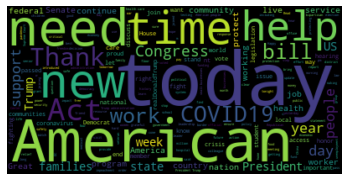

In [16]:
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) 
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

The word clouds seems make sense. Now we move to EDA. (Word clouds is also an EDA approach but here I use it more like a sanity check).

In [17]:
# Delete empty cells/tokens (keep tweets with >2 characters after pre-processing) and remove line breaks

#Drop token that are just brackets
congress_tweets['length_tokens']=congress_tweets['tokens'].str.len()
congress_tweets_notempty=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])

#Length of smallest tweet
congress_tweets_notempty['tokens'].str.len().min()

#Remove line breaks
def remove_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#Passing function to 'text'
congress_tweets_notempty['text'] = congress_tweets_notempty['text'].apply(remove_lbreaks)

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1 visualizing n-grams

In [18]:
# collapse our tokens back into strings with the join() string method.
congress_tweets_notempty['tokens'] = congress_tweets_notempty['tokens'].map(lambda text: ' '.join(text))
congress_tweets_notempty['tokens']

0      Sam guys deal experienced teammate But podium ...
1      It great Skype w StuartPublicSch government cl...
2                                  brianstelter 170 days
3      SenateDems We fought hard sure nonprofits size...
4      This illegal act shows rule law Maduro Venezue...
                             ...                        
995    Protecting Great Lakes DNA Michiganders critic...
996    Implementing Huawei technology national infras...
997    Sarah Pitlyk lacks basic qualifications experi...
998    For fourth consecutive day Mississippis number...
999    They provide needed relief local restaurants l...
Name: tokens, Length: 991, dtype: object

In [19]:
congress_tweets_notempty.head(2)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_URLremoved,tokens,length_tokens
0,11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,Sam &amp; the guys had to deal with a less exp...,Dan Sullivan,Sen,3-Jan-15,11/13/1964,M,AK,Senate,Republican,"163,387","116,454","122,640","164,676",Sam &amp; the guys had to deal with a less exp...,Sam guys deal experienced teammate But podium ...,23
1,479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,It was great to @Skype w @StuartPublicSch’s go...,Deb Fischer,Sen,3-Jan-13,3/1/1951,F,NE,Senate,Republican,"495,961","284,494","302,081","475,064",It was great to @Skype w @StuartPublicSch’s go...,It great Skype w StuartPublicSch government cl...,24


In [20]:
# initialize the BOW countervectorizer
# the ngram_range argument. ngram_range=(1,2) is do to a unigram (1-gram) and a bigram (2-gram) 
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,3)) # n-gram is a bigram and a 3-gram
ngrams = countvec.fit_transform(congress_tweets_notempty['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

/Users/rachel/miniforge3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/rachel/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
# see how each 2-grams or 3-grams show up in each row/individual
dictionary_dataframe.head()

,10 celebrated,10 celebrated harriet,10 covid,10 covid states,10 million,10 million scientist,10 people,10 pm,10 pm week,10 years,...,zip code,zip code economic,zones act,zones act repanthonybrown,zones expand,zones expand exact,zoo nt,zoo nt know,zulu acherry13,zulu acherry13 gov
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# counts how many times each of the 2-grams and 3-grams show up across all document 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head() 

,ngrams,freq
0,american people,23
1,president trump,21
2,health care,20
3,trump administration,19
4,small businesses,17


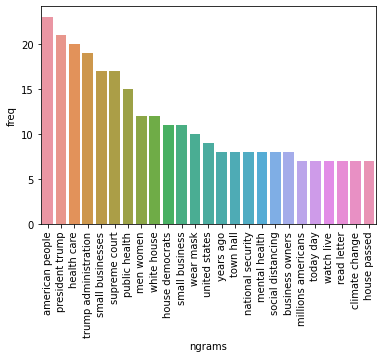

In [23]:
# plot the top 25 n-grams 
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25]) 
plt.xticks(rotation=90)
plt.show()

It seems the top 25 n-grams contains words that are suggestive of topics like **People** ("american people", "millions americans"), **Health** ("health care", "public health", "mental health"), **Government and Politics** ("trump administration", "supreme court", "house democrats", "town hall", "house passed"), **Country/Nation** ("united states", "national securitry"), **COVID-19** ("wear mask", "social distancing"), **Business** ("small business"), etc. These messages are not indicative toward our prediciton tasks but just help us know potential themes in the tweets. Let's use topic modeling to see if these topics will appear and which topics may be good predictors of party membership or senator vs. rep positions.

### EDA 2 Latent Dirichlet Allocation (LDA) for topic modeling

In [24]:
# create tf-idf matrix 

X = congress_tweets_notempty['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)  # initialize the function, name it as 'tf'

tfidf_matrix =  tf.fit_transform(X)  
dense_matrix = tfidf_matrix.todense()

In [25]:
dense_matrix 
# tf-idf ranges from 0 to 1. The closer to 1, the word is more distinguishing. 
# I don't see any 1?? 

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
# apply the LDA model. set n_components= 6 to see what we get. 
lda = LatentDirichletAllocation(n_components=6, max_iter=20, random_state=0) 

# use LDA model to fit the data 
lda = lda.fit(dense_matrix)

/Users/rachel/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [27]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [28]:
# see the 6 topics and print out the top 20 words in each topic
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20) 


Topic #0:
     trump families ” president “ 
  act today care america relief 
 border covid19 bill americans security free

Topic #1:
   today   time day 
  work thank covid19 country small act congress learn health women world 
 
  protect businesses

Topic #2:
     today new 
 president people house families trump support health great week american act americans – protect ”

Topic #3:
     
  today “ ” president congress trump time americans join act health new help live people realdonaldtrump need

Topic #4:
   
    covid19 people need support today thank help economy president house ️ health congress bill work trump working

Topic #5:

    help    need health federal community president americans know 
 trump fighting bill testing 
 
  national ️ public



/Users/rachel/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Based on the top 20 words in each topic, it seems topic 0, 2, 3, 4 is about COVID-19 and health care, topic 1 and 5 is about today's community and work. All of them are related to the pandemic. Overall these topics seem more interelated than distinguishable from each other. 

Now we compare the prevalence of each topic across individuals by merging the topic distribution back into the Pandas dataframe.

In [29]:
# get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.84750323, 0.03045568, 0.03047058, 0.03053955, 0.03056528,
        0.03046568],
       [0.02995081, 0.02987264, 0.02998733, 0.03011535, 0.85019679,
        0.02987708],
       [0.06140652, 0.06189021, 0.06162402, 0.06165146, 0.69204859,
        0.0613792 ],
       ...,
       [0.02523732, 0.025318  , 0.02538625, 0.87366706, 0.02516874,
        0.02522263],
       [0.02300215, 0.02317378, 0.02280666, 0.02289908, 0.88508395,
        0.02303438],
       [0.03326365, 0.03327276, 0.03318553, 0.03318189, 0.03321299,
        0.83388317]])

In [30]:
# merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets_notempty.reset_index())
df_w_topics.head(5)


,0,1,2,3,4,5,level_0,index,tweet_id,screen_name,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_URLremoved,tokens,length_tokens
0,0.847503,0.030456,0.030471,0.030540,0.030565,0.030466,0,11361,1.132820e+18,SenDanSullivan,...,AK,Senate,Republican,"163,387","116,454","122,640","164,676",Sam &amp; the guys had to deal with a less exp...,Sam guys deal experienced teammate But podium ...,23
1,0.029951,0.029873,0.029987,0.030115,0.850197,0.029877,1,479436,1.125490e+18,SenatorFischer,...,NE,Senate,Republican,"495,961","284,494","302,081","475,064",It was great to @Skype w @StuartPublicSch’s go...,It great Skype w StuartPublicSch government cl...,24
2,0.061407,0.061890,0.061624,0.061651,0.692049,0.061379,2,866557,1.166860e+18,RepDonBeyer,...,VA,8,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522",RT @brianstelter 170 days.\n\n,brianstelter 170 days,3
3,0.031217,0.031109,0.031053,0.031192,0.031204,0.844225,3,168486,1.242860e+18,SenatorBennet,...,CO,Senate,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243",@SenateDems We fought hard to make sure nonpro...,SenateDems We fought hard sure nonprofits size...,21
4,0.827898,0.034386,0.034415,0.034561,0.034385,0.034355,4,507812,1.126490e+18,RepSires,...,NJ,8,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",This illegal act shows once again there is no ...,This illegal act shows rule law Maduro Venezue...,20


In each row (which is each person's tweet), we can see the percentages represent the proportion of variation explained by each topic. For example for person 0, topic 1 explains more variations (0.847596), for person 1, topic 2 explain more variations. Now we can check the average weight of each topic across 'party' (each person's party membership) using *groupby*.

In [31]:
# check the average weight of each topic across 'party' 
grouped = df_w_topics.groupby('party')
for i in range(0, 6):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.231200
Democrat       0.178804
Republican     0.167153
Name: 0, dtype: float64
party
Democrat       0.164280
Republican     0.158846
Independent    0.031377
Name: 1, dtype: float64
party
Democrat       0.176374
Republican     0.172609
Independent    0.031385
Name: 2, dtype: float64
party
Independent    0.234444
Democrat       0.177786
Republican     0.166878
Name: 3, dtype: float64
party
Independent    0.234469
Republican     0.199155
Democrat       0.158620
Name: 4, dtype: float64
party
Independent    0.237125
Democrat       0.144136
Republican     0.135358
Name: 5, dtype: float64


Topic 2 seems to have fair separation between Independent or Republican/Democrat, so do topic 0 and 3. This aligns with our impression on the initial redults of topic modeling (i.e., overall these topics seem more interelated than distinguishable from each other). Let's plot topic 2 by party. 

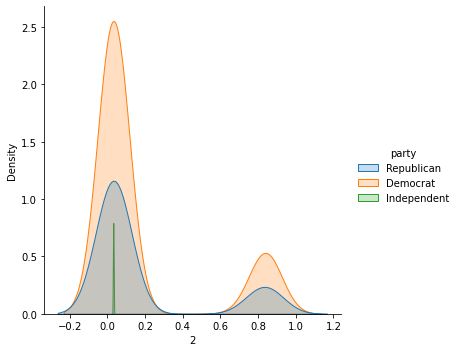

In [32]:
sns.displot(df_w_topics, x=df_w_topics[2], hue = "party", kind = 'kde', fill = 'true')
plt.show()

In [33]:
# check the average weight of each topic across 'position' 
grouped = df_w_topics.groupby('position')
for i in range(0, 6):
    print(grouped[i].mean().sort_values(ascending=False))

position
Sen    0.187925
Rep    0.171334
Name: 0, dtype: float64
position
Rep    0.169404
Sen    0.136432
Name: 1, dtype: float64
position
Rep    0.180524
Sen    0.154095
Name: 2, dtype: float64
position
Sen    0.189087
Rep    0.170021
Name: 3, dtype: float64
position
Sen    0.193518
Rep    0.166387
Name: 4, dtype: float64
position
Rep    0.142331
Sen    0.138943
Name: 5, dtype: float64


Topics are even less distinguishable across positions (senator or representative). See a plot for topic 4:

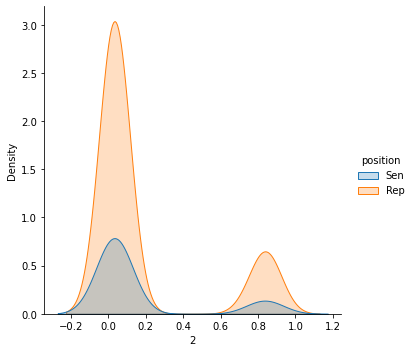

In [34]:
sns.displot(df_w_topics, x=df_w_topics[2], hue = "position", kind = 'kde', fill = 'true')
plt.show()

**Summary of EDA**: Results from n-grams (we used 2- and 3-grams) and Latent Dirichlet Allocation (LDA) topic modeling suggest that topics surface from the tweeter text are related to people, government and politics, country/nation, COVID-19 and health care, business, community and work, etc. Overall these topics seem more interelated than distinguishable from each other. Toward our prediciton tasks (whether the person behind the tweeter text is a democrat, republican, or independent; or a senator or representative), these topics generally seems not strongly associate with what we want to predict. We need further analyses to see if tweeter text is indicative of prople's party membership and congress position. 


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

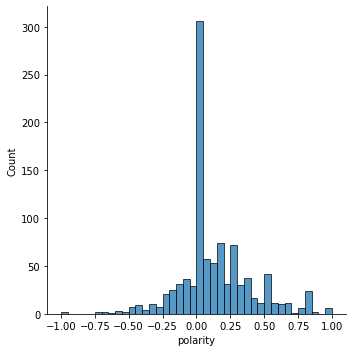

In [47]:
# examine the overall sentiment distribution in our dataset
congress_tweets_notempty["polarity"] = congress_tweets_notempty['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets_notempty, x="polarity")
plt.show()

We begin by looking at the overall distribution of legislators' sentiments in their tweets (within our sample). Specifically, we look at polarity, which analyzes the negative vs. positive sentiment of a tweet using a range of -1 to 1. We see that the vast majority of tweets are relatively neutral, and that a slight majority are classified as positive. 

In [48]:
# Identify Legislators with the Most Tweets in our Sample
congress_tweets_notempty.groupby('screen_name').state.count().sort_values(ascending=False)

screen_name
RepDonBeyer        16
RepAndyBiggsAZ     15
RepJayapal         13
RepMaloney         11
JohnCornyn         11
                   ..
RepTedBudd          1
RepGallagher        1
RepGarretGraves     1
RepGregPence        1
RepKayGranger       1
Name: state, Length: 345, dtype: int64

To decide which legislators to pick for this exercise, we first look at which senators in our sample have the highest number of tweets. We select the most frequently occuring Democrat (Representative Don Beyer) and Republican (Representative Andy Biggs) legislator in our sample.

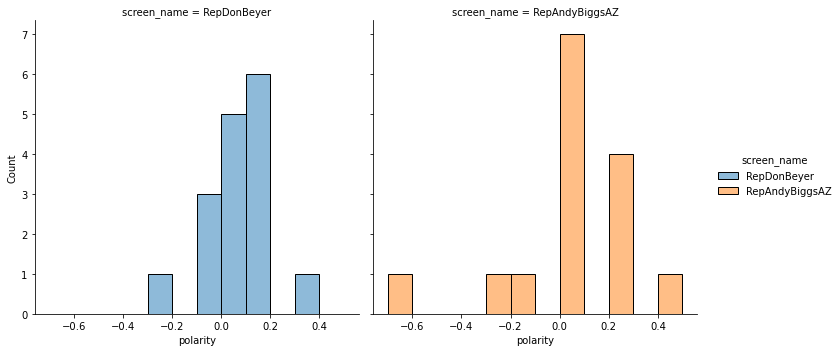

In [49]:
# Plot polarity distributions for selected legilators
beyer_biggs_tweets = congress_tweets_notempty[congress_tweets_notempty['screen_name'].isin(['RepDonBeyer','RepAndyBiggsAZ'])]

sns.displot(beyer_biggs_tweets, x="polarity", hue = 'screen_name', col = 'screen_name')
plt.show()

From this side-by-side comparison, we see that both representatives have mostly neutral tweets. This is congruent with the overall pattern we saw above. However, we do note that Representative Andy Biggs has one very negative tweet (<-0.06), while Representative Beyer does not.

party
Democrat       654
Republican     333
Independent      4
Name: state, dtype: int64

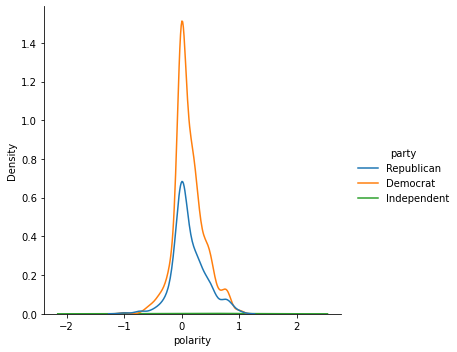

In [50]:
# Plot polarity distribution for Democrats, Republicans, and Independents
sns.displot(congress_tweets_notempty, x="polarity", hue="party", kind='kde')

# Display number of tweets by party
congress_tweets_notempty.groupby('party').state.count().sort_values(ascending=False)

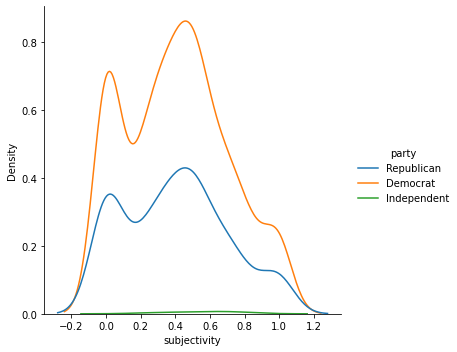

In [51]:
# Plot subjectivity distribution for Democrats, Republicans, and Independents
congress_tweets_notempty['subjectivity'] = congress_tweets_notempty['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets_notempty, x="subjectivity", hue="party", kind='kde')

Here, we overlay the distribution of both polarity and subjectivity for all 3 political parties in our dataset, though we focus on the comparison between Republicans and Democrats. The addition of subjectivity allows us to quantify the amount of personal opinion vs. factural information contained in legislators tweets. While Democrats (n=660) have higher tweet frequency than Republicans (n=336) in our sample, we see extremely similar patterns across both groups. Democrats and Republicans appear to tweet with the same frequency of positivity/negativity, and both parties tend to tweet more subjective information than objective, fact-based information. The bimodal nature of the subjectivity plot is interesting, and may be something to explore in future analyses!

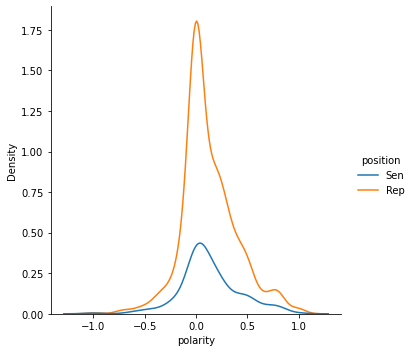

In [52]:
# Plot polarity distribution for Senators vs. Representatives
sns.displot(congress_tweets_notempty, x="polarity", hue="position", kind="kde")

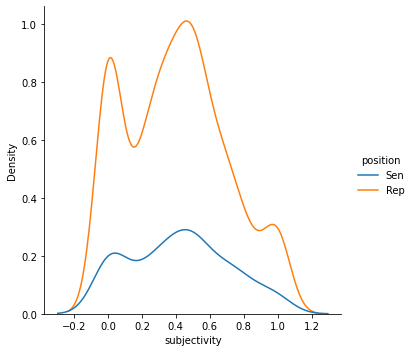

In [53]:
# Plot subjectivity distribution for Senators vs. Representatives
sns.displot(congress_tweets_notempty, x="subjectivity", hue="position", kind="kde")

Here, we overlay the distribution of both polarity and subjectivity for legislators in the house and the senate. We see more tweets from representatives than senators, which is logical because the United States congress consists of 100 total senators and 435 representatives. Overall, legislators in the house and the senate display similar patterns of posting positive/negative information and factual/subjective information. Some differences between these groups were anticipated given the difference in term lengths for members of the house (2 years) and senate (6 years). From our sample, it does not appear that differences in re-election frequency are associated with tweet sentiment.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [54]:
# Engineered Features
engineered_features = congress_tweets_notempty[['polarity', 'subjectivity']].reset_index(drop = True)

# Engineered Features with Topics
engineered_features_with_topics = topic_dist_df.join(congress_tweets_notempty.reset_index(drop = True))

In [55]:
engineered_features

,polarity,subjectivity
0,0.400000,0.533333
1,0.733333,0.683333
2,0.000000,0.000000
3,0.085417,0.474306
4,-0.500000,0.500000
...,...,...
986,0.533333,0.850000
987,-0.025000,0.200000
988,-0.050000,0.112500
989,-0.006370,0.489765


In [56]:
engineered_features_with_topics

,0,1,2,3,4,5,index,tweet_id,screen_name,datetime,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_URLremoved,tokens,length_tokens,polarity,subjectivity
0,0.847503,0.030456,0.030471,0.030540,0.030565,0.030466,11361,1.132820e+18,SenDanSullivan,2019-05-26T21:36:32-04:00,...,Republican,"163,387","116,454","122,640","164,676",Sam &amp; the guys had to deal with a less exp...,Sam guys deal experienced teammate But podium ...,23,0.400000,0.533333
1,0.029951,0.029873,0.029987,0.030115,0.850197,0.029877,479436,1.125490e+18,SenatorFischer,2019-05-06T16:15:46-04:00,...,Republican,"495,961","284,494","302,081","475,064",It was great to @Skype w @StuartPublicSch’s go...,It great Skype w StuartPublicSch government cl...,24,0.733333,0.683333
2,0.061407,0.061890,0.061624,0.061651,0.692049,0.061379,866557,1.166860e+18,RepDonBeyer,2019-08-28T19:44:44-04:00,...,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522",RT @brianstelter 170 days.\n\n,brianstelter 170 days,3,0.000000,0.000000
3,0.031217,0.031109,0.031053,0.031192,0.031204,0.844225,168486,1.242860e+18,SenatorBennet,2020-03-25T13:14:12-04:00,...,Democrat,"1,202,484","1,338,870","1,323,102","1,185,243",@SenateDems We fought hard to make sure nonpro...,SenateDems We fought hard sure nonprofits size...,21,0.085417,0.474306
4,0.827898,0.034386,0.034415,0.034561,0.034385,0.034355,507812,1.126490e+18,RepSires,2019-05-09T10:26:11-04:00,...,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",This illegal act shows once again there is no ...,This illegal act shows rule law Maduro Venezue...,20,-0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,0.033597,0.033809,0.033848,0.033802,0.831274,0.033671,426557,1.235730e+18,SenGaryPeters,2020-03-05T19:33:35-05:00,...,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256",Protecting our Great Lakes is part of our DNA ...,Protecting Great Lakes DNA Michiganders critic...,21,0.533333,0.850000
987,0.030898,0.030885,0.030999,0.030863,0.030921,0.845434,227593,1.221880e+18,RepTedYoho,2020-01-27T14:38:17-05:00,...,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",Implementing #Huawei technology into national ...,Implementing Huawei technology national infras...,20,-0.025000,0.200000
988,0.025237,0.025318,0.025386,0.873667,0.025169,0.025223,288757,1.201600e+18,SenatorDurbin,2019-12-02T15:38:59-05:00,...,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216",Sarah Pitlyk lacks the basic qualifications an...,Sarah Pitlyk lacks basic qualifications experi...,49,-0.050000,0.112500
989,0.023002,0.023174,0.022807,0.022899,0.885084,0.023034,460038,1.283480e+18,CongPalazzo,2020-07-15T15:03:58-04:00,...,Republican,"700,714","485,131","562,949","710,746","For the fourth consecutive day, Mississippi's ...",For fourth consecutive day Mississippis number...,59,-0.006370,0.489765


We use polarity and subjectivity to engineer our text features. As we learned in lab, we can use either engineered features alone, or engineered features with topics identified from our prior LDA anlaysis.

### Bag-of-words or Tf-idf

In [57]:
# Frequency Based featurization
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

/Users/rachel/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
tfidf_df

,\n,\n\n\n\n,\n\n\n,\n\n,\n\n,\n,\n \n,\n \n,\n,\n,...,🙌,🙏,🚌,🚗,🚨,🚫,🛒,🤯,🥫,🧼
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
987,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
988,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
989,0.0,0.0,0.0,0.0,0.0,0.317387,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [46]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

In [47]:
##We obtain the tokens one more time. 
congress_tweets_notempty['tokens'] = congress_tweets_notempty'text_URLremoved'].map(lambda x: rem_punc_stop(x))

In [59]:
congress_tweets_notempty['tokens'][0]

'Sam guys deal experienced teammate But podium 3rd place teammates gracious Fortunately Sam alltime race record 109 stands Congrats winners competed Kodiak crabfest2019'

In [49]:
##We apply a model for Word2vec using the congress tweets. 
word2vec_model = gensim.models.Word2Vec(congress_tweets_notempty['tokens'], window=5, 
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [50]:
model.vector_size

300

In [51]:
len(congress_tweets_notempty['tokens'][0])

23

In [60]:
doc = [word for word in congress_tweets_notempty['tokens'][1] if word in model.key_to_index]
len(doc)

NameError: name 'model' is not defined

In [61]:
doc[0:6]

NameError: name 'doc' is not defined

In [62]:
print(model.__getitem__('class'))
vector = model.get_vector('class', norm=True)
vector.shape

NameError: name 'model' is not defined

In [63]:
numpy.mean(model.__getitem__('class'))

NameError: name 'model' is not defined

In [56]:
##We obtain the average over the vectors
first_vec = []
for token in model.__getitem__(doc):
    first_vec.append(token[0])
numpy.mean(first_vec)

-0.038907815

In [57]:
congress_tweets_notempty['tokens'][1]

['It',
 'great',
 'Skype',
 'w',
 'StuartPublicSch',
 'government',
 'class',
 'morning',
 'discuss',
 'number',
 'important',
 'topics',
 'Congratulations',
 'seniors',
 'upcoming',
 'graduation',
 'weekend',
 'I',
 'wish',
 'best',
 'chapter',
 'TomorrowsLeaders',
 'LoveNE',
 ' ']

In [58]:
word2vec_model = gensim.models.Word2Vec(congress_tweets_notempty['tokens'], window=5, 
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [59]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.key_to_index]
    return numpy.mean(model[doc], axis=0)

In [60]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for x in congress_tweets_notempty['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, x))
    
doc_average_embeddings = numpy.wv.array(empty_list_embeddings_means) # list to array

##Question for KQ, not sure why the output says that there is no array?


ValueError: need at least one array to concatenate

@sociologyquinn not sure why the output says that there is no array?. I'm not really sure if I fully understand what's going on.


In [ ]:
doc_average_embeddings = numpy.array(documents) # list to array

In [ ]:
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array

In [ ]:
doc_average_embeddings

In [ ]:
doc_average_embeddings.shape

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

We will use logistic regression as our supervised algorithm. 

## For KQ: Just checking the models look okish. They look similar to the results from lab, but we get a message of string vs int. *

In [61]:
##Call the appropriate functions

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression

In [64]:
congress_tweets_notempty['position']

0      Sen
1      Sen
2      Rep
3      Sen
4      Rep
      ... 
995    Sen
996    Rep
997    Sen
998    Rep
999    Rep
Name: position, Length: 991, dtype: object

In [63]:
dataframes = [engineered_features, 
              engineered_features_with_topics, tfidf_df]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model', 
                            'Tf-idf Features']

lb_style = LabelBinarizer()
y = congress_tweets_notempty['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

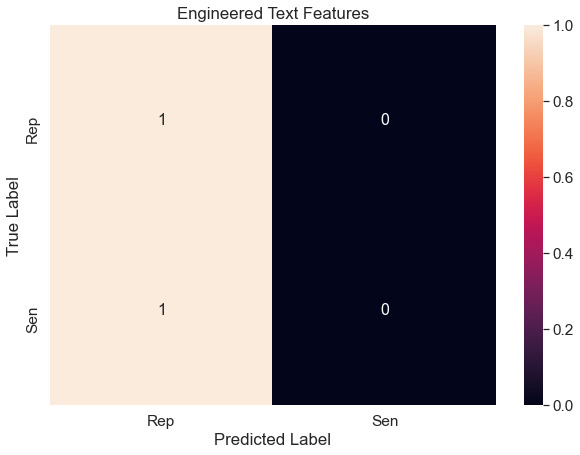

/Users/evalencialopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/evalencialopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


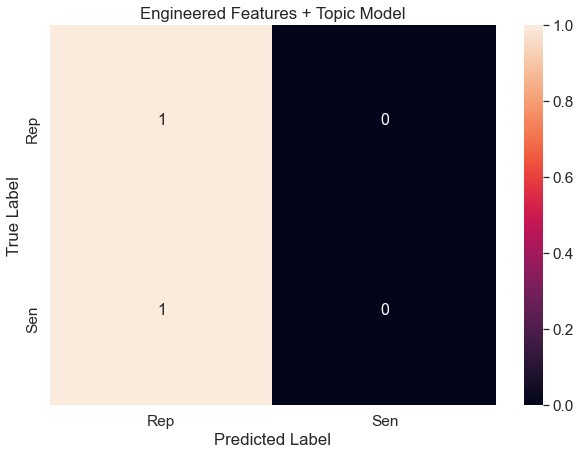

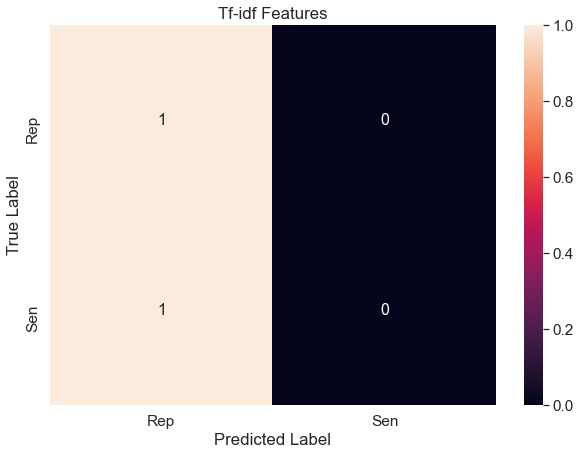

In [64]:
##Senator or representative
###Predict democrat or republican
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Rep", 1: "Sen"})
    df_cm.index = ["Rep", "Sen"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [65]:

congress_tweets_notempty["party"].value_counts()

Democrat       660
Republican     336
Independent      4
Name: party, dtype: int64

In [66]:
congress_tweets_notempty["party_dummy"] = congress_tweets_notempty["party"].apply(lambda x: 1 if x == "Democrat" else 0)
congress_tweets_notempty["party_dummy"]

0      0
1      0
2      1
3      1
4      1
      ..
995    1
996    0
997    1
998    0
999    1
Name: party_dummy, Length: 1000, dtype: int64

In [67]:
congress_tweets_notempty["party_dummy"].value_counts()

1    660
0    340
Name: party_dummy, dtype: int64

In [69]:
dataframes = [engineered_features, 
              engineered_features_with_topics, tfidf_df]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model', 
                            'Tf-idf Features']

lb_style = LabelBinarizer()
y = congress_tweets_notempty['party_binary'] = lb_style.fit_transform(congress_tweets_notempty["party_dummy"])

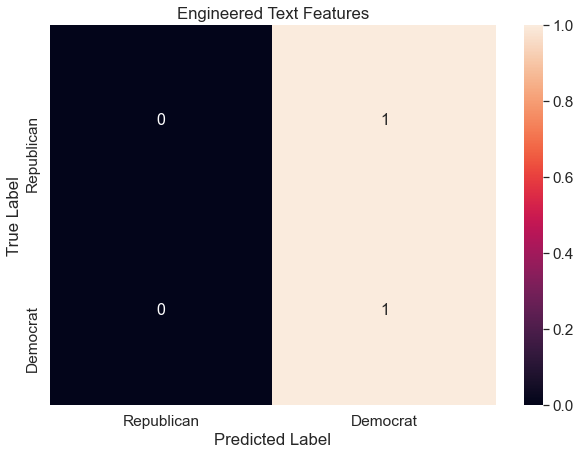

/Users/evalencialopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/evalencialopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


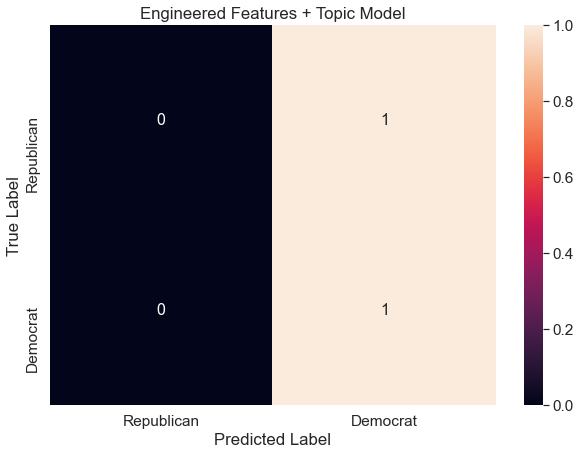

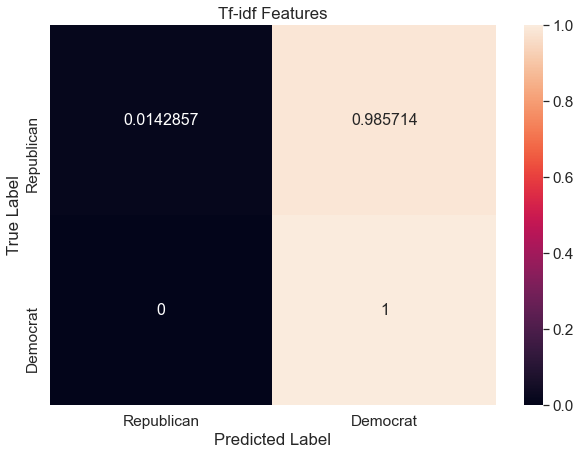

In [70]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
###Predict democrat or republican
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics.

We are going to use the engineering features with non-text and a combined model. 

### Two Combined Models

In [81]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# Non-text features
non_text_features = congress_tweets_notempty[['index','tweet_id','datetime','joined_congress_date','clinton_2016_state_share', 'obama_2012_state_share','romney_2012_state_share']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names_out())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)


In [82]:
dataframes = [non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf]

featurization_technique = ['Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features']

lb_style = LabelBinarizer()
y = congress_tweets_notempty['party_binary'] = lb_style.fit_transform(congress_tweets_notempty["party_dummy"])

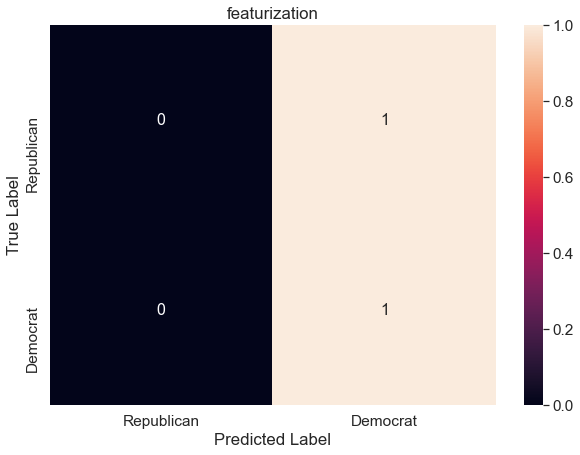

/Users/evalencialopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/evalencialopez/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


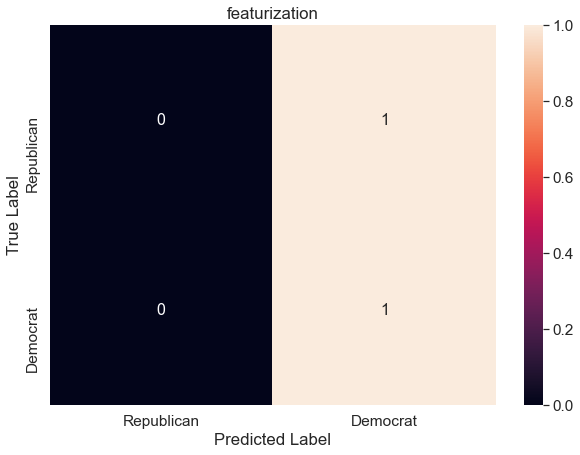

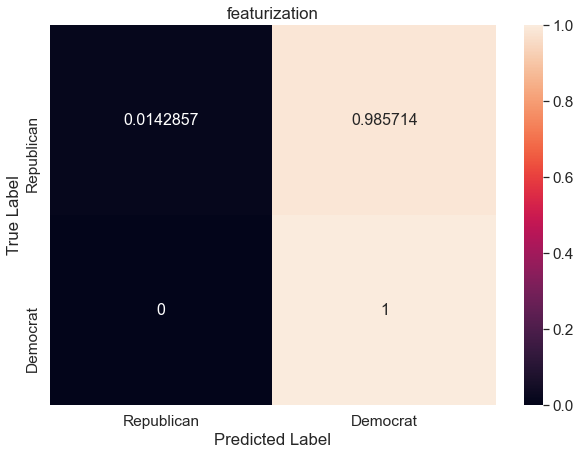

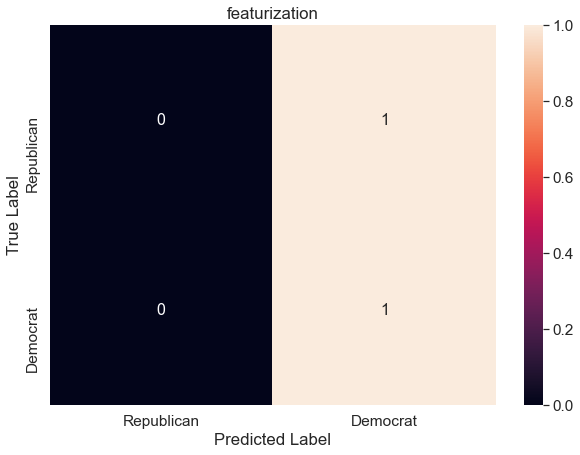

In [83]:
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title("featurization")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?



**A particular corpus has its own linguistic characteristics that require specific preprocessing techniques to deal with in a way that makes features/words more representative of the text's meaning. In our twitter data analysis, we see that certain stop words (such as “RT” or “QT”) and punctuation marks, for example, are unique to our dataset and necessitate unique coding that would be irrelevant to other bodies of text. Also, we need to consider prediction tasks, analytical goals, and relevant computational time when deciding what preprocessing techniques to use.
Depending on the purpose of the analysis, we will also need to customize the corpus to reduce noise, sparseness and increase precision in the modeling stage.**



2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Our preliminary analyses indicated that Democrats and Republicans may not differ substantially in the sentiment of their tweets. Both Democrats and Republicans appear to post mostly neutral tweets, and interject some degree of subjectivity into their content. The data did not seem particularly skewed for one group versus the other.
Similarly, our preliminary analyses indicated that Senators and Representatives may not differ substantially in the sentiments of their tweets. We hypothesized that the difference in term length may affect tweet sentiment; would more frequent re-election considerations lead to more emotional or positive tweets? Our results did not indicate that this was the case. Senators and Representatives tweet predominantly neutral content (both trending slightly more positive), and both display similar patterns of subjectivity in their tweets.**


3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**This is to check if the algorithms perform well and to find out which ways of feature engineering have the best accuracy in prediction. Then we can use the optimal/ validated approach for further work (e.g., labeling or coding the text).**


4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**The intuition is to capture information such as word counts, meanings, sentiments, relationships, etc in the text content and communication dynamics as much as possible.**